<a href="https://colab.research.google.com/github/tasn19/DataAnalyticsFlightPatterns/blob/main/ForecastNumFlights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Download & unzip - optional
Or download parquet files and proceed to 

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp /content/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download --force robikscube/flight-delay-dataset-20182022

In [ ]:
import zipfile
! unzip -q /content/flight-delay-dataset-20182022.zip -d Airlines

##Preprocess & save data

In [ ]:
!pip install pyspark

In [ ]:
import pyspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

#Loading all csvs into dataframes

years = ['2018', '2019', '2020', '2021', '2022']
dfs = []

spark = SparkSession.builder.master("local[1]") \
          .appName("SparkByExamples.com") \
          .getOrCreate()

for y in years:
  df = spark.read.options(header='True', inferSchema='True').csv(f"Airlines/Combined_Flights_{y}.csv")
  dfs.append(df)

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql.functions import udf
from pyspark.sql.functions import when
from pyspark.sql.functions import lit


# DEFs
def time_to_hour(x):
  if x == '-1':
    return '-1'
  
  return x[:2] if len(x) == 4 else x[:1]

def time_to_minute(x):
  if x == '-1':
    return '-1'

  if len(x) >= 3:
    return x[-2:]
  
  return 0

# UDFs

udf_time_to_hour = udf(time_to_hour, StringType())
udf_time_to_minute = udf(time_to_minute, StringType())
# udf_range_to_name = udf(lambda x: 'Late Night' if x == 1 else 
#                         'Early Morning' if x == 2 else
#                         'Morning' if x == 3 else
#                         'Noon' if x == 4 else
#                         'Evening' if x == 5 else
#                         'Night' if x == 6 else
#                         'ERROR'
#                         , StringType())
udf_to_is_delay = udf(lambda x: 1 if x > 0 else 0, IntegerType())
udf_to_is_early = udf(lambda x: 1 if x < 0 else 0, IntegerType())
udf_dist_to_sh_lo = udf(lambda x: 0 if x < 790 else 1, IntegerType())
udf_day_to_mo_half = udf(lambda x: 0 if x <= 15 else 1, IntegerType())
udf_city_to_state = udf(lambda x: x.split(',')[0], StringType())

West = ['WA','OR','ID','MT','CA','NV','UT','AZ','CO','NM','AK','WY'] 
MidWest = ['ND','SD','NE','KS','MN','IA','MO','WI','IL','MI','IN','OH'] 
South = ['TX','OK','LA','AR','MS','AL','TN','KY','WV','FL','GA','SC','NC','VA','MD','DC','DE'] 
NorthEast = ['PA','NY','VT','NJ','CT','RI','MA','NH','ME','PR','VI']
udf_state_to_geo = udf(lambda x: 0 if x in West else # west
                      1 if x in MidWest else # midwest
                      2 if x in South else # south
                      3 if x in NorthEast else # northeast
                      4 # error
                      , IntegerType())


#Pre-processing code
def pre_process(df):
  # we should have two fillna s because:
  # each time pyspark will fill the nulls of the given type
  df = df.fillna('-1')
  df = df.fillna(-1)
  df = df.withColumn("Cancelled",col("Cancelled").cast("Integer"))
  df = df.withColumn("Diverted",col("Diverted").cast("Integer"))

  df = df.withColumn("CRSDepTime",col("CRSDepTime").cast("Integer"))
  df = df.withColumn("CRSDepTime",col("CRSDepTime").cast("String"))
  df = df.withColumn("DepTime",col("DepTime").cast("Integer"))
  df = df.withColumn("DepTime",col("DepTime").cast("String"))

  df = df.withColumn("CRSDepHour", udf_time_to_hour("CRSDepTime"))
  df = df.withColumn("CRSDepHour",col("CRSDepHour").cast("Integer"))

  df = df.withColumn("DepHour", udf_time_to_hour("DepTime"))
  df = df.withColumn("DepHour",col("DepHour").cast("Integer"))

  df = df.withColumn("DepMinutes", udf_time_to_minute("DepTime"))
  df = df.withColumn("DepMinutes",col("DepMinutes").cast("Integer"))

  df = df.withColumn("IsDepDelay", udf_to_is_delay("DepDelay"))
  df = df.withColumn("IsDepEarly", udf_to_is_early("DepDelay"))

  # Same pre-processing techniques as applied to departure columns

  df = df.withColumn("CRSArrTime",col("CRSArrTime").cast("Integer"))
  df = df.withColumn("CRSArrTime",col("CRSArrTime").cast("String"))
  df = df.withColumn("ArrTime",col("ArrTime").cast("Integer"))
  df = df.withColumn("ArrTime",col("ArrTime").cast("String"))

  df = df.withColumn("CRSArrHour", udf_time_to_hour("CRSArrTime"))
  df = df.withColumn("CRSArrHour",col("CRSArrHour").cast("Integer"))
  
  df = df.withColumn("ArrHour", udf_time_to_hour("ArrTime"))
  df = df.withColumn("ArrHour",col("ArrHour").cast("Integer"))
  
  df = df.withColumn("ArrMinutes", udf_time_to_minute("ArrTime"))
  df = df.withColumn("ArrMinutes",col("ArrMinutes").cast("Integer"))

  df = df.withColumn("IsArrDelay", udf_to_is_delay("ArrDelay"))
  df = df.withColumn("IsArrEarly", udf_to_is_early("ArrDelay"))

  df = df.withColumn("ShortOrLong", udf_dist_to_sh_lo("Distance"))
  df = df.withColumn("TimeofMonth", udf_day_to_mo_half("DayofMonth"))

  df = df.withColumn("OriginCityName", udf_city_to_state("OriginCityName"))
  df = df.withColumn("DestCityName", udf_city_to_state("DestCityName"))

  df = df.withColumn("GeoOrientation", udf_state_to_geo("OriginState"))

  df = df.withColumn("DepDelayMinutes",col("DepDelayMinutes").cast("Integer"))
  df = df.withColumn("AirTime",col("AirTime").cast("Integer"))
  df = df.withColumn("ActualElapsedTime",col("ActualElapsedTime").cast("Integer"))
  df = df.withColumn("ArrDelayMinutes",col("ArrDelayMinutes").cast("Integer"))
  df = df.withColumn("TaxiOut",col("TaxiOut").cast("Integer"))
  df = df.withColumn("TaxiIn",col("TaxiIn").cast("Integer"))

  # I Tried this and it worked. Created 3 categories pre-pandemic - 1 , pandemic - 2, post pandemic - 3 - Mithila
  # Note - Please double check if the conditions are correct :)
  # Travel ban started March 2020 and ended November 2021 in the USA
  df = df.withColumn("Pandemic", \
    when((df.Year <= 2020) & (df.Month <= 3), 1) \
      .when((df.Year >= 2021) & (df.Month >= 11), 3) \
      .otherwise(2) \
    )

  to_be_dropped = ('Distance',
                   'WheelsOff',
                   #'DayofMonth', # TN - don't remove, needed for combining all flights per day
                   'FlightDate',
                   'CRSDepTime',
                  #  'DepTime', # Rmin: maybe we need it
                   'WheelsOn',
                   'CRSArrTime',
                  #  'ArrTime', # Rmin: maybe we need it
                   'ArrDelay',
                   'OriginStateName',
                   'DestStateName',
                   'Operated_or_Branded_Code_Share_Partners',
                   'DOT_ID_Marketing_Airline',
                   'IATA_Code_Marketing_Airline',
                   'Flight_Number_Marketing_Airline',
                   'DOT_ID_Operating_Airline',
                   'IATA_Code_Operating_Airline',
                   'Tail_Number',
                   'Flight_Number_Operating_Airline',
                   'OriginAirportID',
                   'OriginAirportSeqID',
                   'OriginCityMarketID',
                   'DestAirportID',
                   'DestAirportSeqID',
                   'DestCityMarketID',
                   'DivAirportLandings',
                   'OriginWac',
                   'OriginStateFips',
                   'DestStateFips',
                   'DestWac',
                   'Marketing_Airline_Network',
                   'DepartureDelayGroups', #Added by Mithila # Rmin: great!
                   'DepTimeBlk',
                   'Operating_Airline',
                   'DepDelay', # we are using DepDelayMinutes instead cuz it doesnt have neg vals for early flights
                   'DepartureDelayGroups',
                   'DepTimeBlk',
                   'ArrivalDelayGroups',
                   'ArrTimeBlk',
                   'CRSElapsedTime',
                   'DistanceGroup', #Do we need this column? # Rmin: no i dont think so
                   'DepDel15',
                   'ArrDel15',
                   'CRSDepTime',
                   'DepTime',
                   'CRSArrTime',
                   'ArrTime'
                   )
  
  df = df.drop(*to_be_dropped)

  return df

In [ ]:
pp_dfs = [pre_process(df) for df in dfs]

In [ ]:
pp_dfs[0].show()

+-----------------+------+----+---------+--------+---------------+---------------+-------+-----------------+----+-------+-----+----------+---------+--------------+-----------+------------+---------+-------+------+----------+-------+----------+----------+----------+----------+-------+----------+----------+----------+-----------+-----------+--------------+--------+
|          Airline|Origin|Dest|Cancelled|Diverted|DepDelayMinutes|ArrDelayMinutes|AirTime|ActualElapsedTime|Year|Quarter|Month|DayofMonth|DayOfWeek|OriginCityName|OriginState|DestCityName|DestState|TaxiOut|TaxiIn|CRSDepHour|DepHour|DepMinutes|IsDepDelay|IsDepEarly|CRSArrHour|ArrHour|ArrMinutes|IsArrDelay|IsArrEarly|ShortOrLong|TimeofMonth|GeoOrientation|Pandemic|
+-----------------+------+----+---------+--------+---------------+---------------+-------+-----------------+----+-------+-----+----------+---------+--------------+-----------+------------+---------+-------+------+----------+-------+----------+----------+----------+---

Encode categorical columns with frequency encoding

In [ ]:
import pyspark.sql.functions as pfn

cat_dfs = []

categorical_columns = ['Airline', 
                       'Origin', 
                       'Dest', 
                       'OriginCityName', 
                       'OriginState',
                       'DestCityName',
                       'DestState',
                       ]
# categorical_columns = []


for df in pp_dfs:
  res = df
  total = df.count()

  for cc in categorical_columns:
    freq = df.groupBy(cc).agg(pfn.count("*") / total).withColumnRenamed(f'(count(1) / {total})', cc + "ID")
    res = res.join(freq, cc, "left") 

  cat_dfs.append(res)


In [ ]:
final_df = cat_dfs[0]

for df in cat_dfs[1:]:
  final_df = final_df.union(df)

In [ ]:
# SAVE AS PARQUET

#final_df.repartition(1).write.option("header", True).format('parquet').save('/content/drive/MyDrive/DA/final_df')

Create dataframe with flights per day combined

In [12]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[1]") \
          .appName("SparkByExamples.com") \
          .getOrCreate()

In [16]:
# READ PARQUET - don't need to do this, can just open smaller parquet
# this file is preprocessed + freq encoded, not one-hot encoded
final_df = spark.read.parquet('/content/drive/MyDrive/DA/preprocessedData.snappy.parquet') 

In [ ]:
final_df.show(n=10)

+---------+------------+-----------+--------------------+----+------+--------------------+---------+--------+---------------+---------------+-------+-----------------+----+-------+-----+----------+---------+-------+------+----------+-------+----------+----------+----------+----------+-------+----------+----------+----------+-----------+-----------+--------------+--------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|DestState|DestCityName|OriginState|      OriginCityName|Dest|Origin|             Airline|Cancelled|Diverted|DepDelayMinutes|ArrDelayMinutes|AirTime|ActualElapsedTime|Year|Quarter|Month|DayofMonth|DayOfWeek|TaxiOut|TaxiIn|CRSDepHour|DepHour|DepMinutes|IsDepDelay|IsDepEarly|CRSArrHour|ArrHour|ArrMinutes|IsArrDelay|IsArrEarly|ShortOrLong|TimeofMonth|GeoOrientation|Pandemic|         AirlineID|            OriginID|              DestID|    OriginCityNameID|       OriginStateID|   

In [ ]:
# Create dataframe with flights per day combined 
from pyspark.sql.functions import concat_ws, year, month

def fix_date(x):
  y, m, d = x.split('-')

  d = d if len(d) == 2 else '0' + d
  m = m if len(m) == 2 else '0' + m

  return f'{y}-{m}-{d}'

udf_fix_date = udf(fix_date, StringType())

# concatenate year-month-day columns
df2 = final_df.select(concat_ws('-', final_df.Year, final_df.Month, final_df.DayofMonth).alias("Date"),"Cancelled", "Diverted", "DepDelayMinutes")

from pyspark.sql.functions import avg, sum, count

df2 = df2.withColumn('Date', udf_fix_date('Date'))
df_flightsPerDay = df2.groupBy('Date').agg(avg('DepDelayMinutes').alias('Avg_Delay'), sum('Cancelled').alias('Sum_Cancelled'), sum('Diverted').alias('Sum_Diverted'), count('*').alias('Num_Flights'))

# convert string to date datatype
from pyspark.sql.functions import to_date
df_flightsPerDay = df_flightsPerDay.withColumn("Date", to_date("Date", "yyyy-MM-dd"))

# Add a pandemic column
df_flightsPerDay = df_flightsPerDay.withColumn("Pandemic", \
    when((year(df_flightsPerDay['Date']) == 2019), 1) \
      .when((year(df_flightsPerDay['Date']) == 2020) & (month(df_flightsPerDay['Date']) <= 3), 1) \
      .when((year(df_flightsPerDay['Date']) == 2020) & (month(df_flightsPerDay['Date']) > 3), 2) \
      .when((year(df_flightsPerDay['Date']) == 2021) & (month(df_flightsPerDay['Date']) <= 11), 2) \
      .otherwise(3) 
    )
#df_flightsPerDay = df_flightsPerDay.withColumm("Pandemic", when((year(df_flightsPerDay.date) <= 2020) & (month(df_flightsPerDay.date) <= 3), 1).when((year(df_flightsPerDay.date) >= 2021) & (month(df_flightsPerDay.date) >= 11), 3).otherwise(2))
                                               

In [ ]:
# SAVE AS PARQUET - save smaller dataset with flights per day combined

#df_flightsPerDay.repartition(1).write.option("header", True).format('parquet').save('/content/drive/MyDrive/DA/forecastDF_correct')

## Load saved dataset of flight statistics per day
Columns included: 
*   date
*   number of flights per day
*   sum of cancellations
*   sum of diversions
*   average delay in minutes
*   pandemic label

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import pandas as pd
dfpd_flights = pd.read_parquet('/content/drive/MyDrive/DA/forecastDF_correct/combinedFlightsperDay.snappy.parquet') 

In [ ]:
dfpd_flights.loc[dfpd_flights['Pandemic'] == 3]

In [ ]:
# sort rows according to date
dfpd_flights = dfpd_flights.sort_values('Date')

In [ ]:
dfpd_flights

,Date,Avg_Delay,Sum_Cancelled,Sum_Diverted,Num_Flights,Pandemic
67,2018-01-01,21.545840,129,33,14147,3
187,2018-01-02,18.592156,110,20,15962,3
357,2018-01-03,14.701765,449,28,15357,3
142,2018-01-04,9.153696,3001,51,15420,3
426,2018-01-05,20.003299,1007,29,15459,3
...,...,...,...,...,...,...
1480,2022-07-27,15.612163,212,58,19815,3
1556,2022-07-28,16.285975,610,54,20841,3
1665,2022-07-29,16.283493,294,98,20833,3
1348,2022-07-30,15.407732,256,43,18468,3


## XGBoost Regressor

In [ ]:
# split up date for model
dfpd_flights["Date"] = pd.to_datetime(dfpd_flights["Date"])
dfpd_flights['month'] = dfpd_flights['Date'].dt.month
dfpd_flights['year'] = dfpd_flights['Date'].dt.year
dfpd_flights['day'] = dfpd_flights['Date'].dt.day

del dfpd_flights['Date']

# move target column to end
dfpd_flights = dfpd_flights[['year', 'month', 'day', 'Avg_Delay', 'Sum_Cancelled', 'Sum_Diverted', 'Pandemic', 'Num_Flights']]

In [ ]:
dfpd_flights

In [ ]:
# TO DO: figure out how to make grid search work, in previous attempts the code did not stop running (see Other section)
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

data = dfpd_flights

# define the number of splits for walk forward validation
n_splits = 25

# initialize the XGB Regressor with default parameters
model = xgb.XGBRegressor()

# initialize variables to keep track of best model
best_model = None
best_mse = float('inf')

features = ['year', 'month', 'day', 'Avg_Delay', 'Sum_Cancelled', 'Sum_Diverted', 'Pandemic']

# loop over the splits
for i in range(n_splits-1):
    # define the train and test sets for the current split
    train_start = 0
    train_end = int((i+1)*len(data)/n_splits)
    test_start = train_end
    test_end = test_start + int(len(data)/n_splits)
    
    train_data = data[train_start:train_end]
    test_data = data[test_start:test_end]
    
    # normalize the data
    scaler = StandardScaler()
    train_data_norm = scaler.fit_transform(train_data)
    test_data_norm = scaler.transform(test_data)
    
    # split the data into features and target
    X_train, y_train = train_data_norm[:,:-1], train_data_norm[:,-1]
    X_test, y_test = test_data_norm[:,:-1], test_data_norm[:,-1]

    # fit the model on the train set
    model.fit(X_train, y_train)
    
    # make predictions on the test set
    y_pred = model.predict(X_test)
    
    # calculate the mean squared error of the predictions
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean squared error for split {i}: {mse}")

    if mse < best_mse:
      best_model = model
      best_mse = mse
      print(f"Best mean squared error for split {i}: {mse}")

In [ ]:
# Reshape y_pred to have shape (n_samples, 1)
y_pred = y_pred.reshape(-1, 1)

# Use the scaler object to denormalize the predictions
y_pred_denorm = scaler.inverse_transform(np.concatenate((X_test, y_pred), axis=1))[:, -1]

In [ ]:
import numpy as np

# generate dates from September 2022 to May 2023
dates = pd.date_range(start='2022-08-01', end='2023-12-31', freq='D')

# create a DataFrame with dates and a column of 3s for 'Pandemic'
df_input = pd.DataFrame({'Date': dates, 'Pandemic': np.ones(len(dates), dtype=int)*3})
df_input[['Avg_Delay' ,	'Sum_Cancelled',	'Sum_Diverted', 'Num_Flights']] = 'NaN'	

# split up date for model
df_input["Date"] = pd.to_datetime(df_input["Date"])
df_input['month'] = df_input['Date'].dt.month
df_input['year'] = df_input['Date'].dt.year
df_input['day'] = df_input['Date'].dt.day

del df_input['Date']

df_input = df_input[['year', 'month', 'day', 'Avg_Delay', 'Sum_Cancelled', 'Sum_Diverted', 'Pandemic', 'Num_Flights']]

# display the DataFrame
print(df_input.head())

In [ ]:
# normalize the new input data
new_input_norm = scaler.transform(df_input)

new_inputF, dummytarget = new_input_norm[:,:-1], new_input_norm[:,-1]

# make predictions on the normalized input data
predictions = model.predict(new_inputF)

# Reshape y_pred to have shape (n_samples, 1)
predictions = predictions.reshape(-1, 1)

# Use the scaler object to denormalize the predictions
predictions_denorm = scaler.inverse_transform(np.concatenate((new_inputF, predictions), axis=1))[:, -1]

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# generate dates from August 2022 to May 2023
dates = pd.date_range(start='2022-08-01', end='2023-12-31', freq='D')

# combine with input data
all_dates = pd.date_range(start='2018-01-01', end='2023-12-31', freq='D')
historic_numflights = dfpd_flights['Num_Flights']
his_flights = historic_numflights.to_numpy()
all_numflights = np.concatenate((his_flights, np.round(predictions_denorm)))

# Add axis labels and a title
fig = plt.figure(figsize = (15, 10))
ax = plt.axes()
# Create the line plot
plt.plot(dates, np.round(predictions_denorm), color ='maroon')
#plt.plot(all_dates, all_numflights)
plt.xlabel('Date', fontsize=25)
plt.ylabel('No. of Flights', fontsize=25)
#plt.title("Flights per day over 2018-2023", fontsize=25)
plt.title("Forecasted Flights per day over 2022-2023", fontsize=25)
# Set y-axis limits to start from 0
plt.ylim(0, 15000)

# Show the plot
plt.show()

#plt.savefig('XGBoostForcasted.png') # NOT WORKING
#plt.savefig('XGBoostAllYrs.png')

In [ ]:
# Add axis labels and a title
fig = plt.figure(figsize = (15, 10))
ax = plt.axes()
# Create the line plot
plt.plot(all_dates, all_numflights)
plt.xlabel('Date', fontsize=25)
plt.ylabel('No. of Flights', fontsize=25)
plt.title("Flights per day over 2018-2023", fontsize=25)
# Set y-axis limits to start from 0
plt.ylim(0, 25000)

# Show the plot
plt.show()

## Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# load the data
data = dfpd_flights

# set the number of splits for walk-forward validation
n_splits = 25

# initialize variables to store the best model and its corresponding mean squared error
best_model1 = None
best_mse1 = np.inf

# loop over the splits
for i in range(n_splits-1):
    # define the train and test sets for the current split
    train_start = 0
    train_end = int((i+1)*len(data)/n_splits)
    test_start = train_end
    test_end = test_start + int(len(data)/n_splits)
    
    train_data = data[train_start:train_end]
    test_data = data[test_start:test_end]
    
    # normalize the data
    scaler1 = StandardScaler()
    train_data_norm = scaler1.fit_transform(train_data)
    test_data_norm = scaler1.transform(test_data)
    
    # split the data into features and target
    X_train, y_train = train_data_norm[:,:-1], train_data_norm[:,-1]
    X_test, y_test = test_data_norm[:,:-1], test_data_norm[:,-1]

    # initialize the model
    model1 = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # fit the model on the train set
    model1.fit(X_train, y_train)
    
    # make predictions on the test set
    y_pred = model1.predict(X_test)
    
    # undo the normalization on the predictions
    #y_pred = scaler.inverse_transform(np.hstack((X_test, y_pred.reshape(-1, 1))))[:, -1]
    
    # calculate the mean squared error of the predictions
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean squared error for split {i}: {mse}")

    if mse < best_mse:
        best_model1 = model1
        best_mse1 = mse
        print(f"Best mean squared error for split {i}: {mse}")
    
    # update the training data for the next split
    train_data = pd.concat([train_data, test_data], axis=0)



In [ ]:
import numpy as np

# generate dates from August 2022 to May 2023
dates = pd.date_range(start='2022-08-01', end='2023-12-31', freq='D')

# create a DataFrame with dates and a column of 3s for 'Pandemic'
df_input = pd.DataFrame({'Date': dates, 'Pandemic': np.ones(len(dates), dtype=int)*3})
df_input[['Avg_Delay' ,	'Sum_Cancelled',	'Sum_Diverted', 'Num_Flights']] = 0	

# split up date for model
df_input["Date"] = pd.to_datetime(df_input["Date"])
df_input['month'] = df_input['Date'].dt.month
df_input['year'] = df_input['Date'].dt.year
df_input['day'] = df_input['Date'].dt.day

del df_input['Date']

df_input = df_input[['year', 'month', 'day', 'Avg_Delay', 'Sum_Cancelled', 'Sum_Diverted', 'Pandemic', 'Num_Flights']]

# display the DataFrame
print(df_input.head())

In [ ]:
# normalize the new input data
new_input_norm = scaler1.transform(df_input)

new_inputF, dummytarget = new_input_norm[:,:-1], new_input_norm[:,-1]

# make predictions on the normalized input data
predictions1 = model1.predict(new_inputF)

# Reshape y_pred to have shape (n_samples, 1)
predictions1 = predictions1.reshape(-1, 1)

# Use the scaler object to denormalize the predictions
predictions_denorm1 = scaler1.inverse_transform(np.concatenate((new_inputF, predictions1), axis=1))[:, -1]

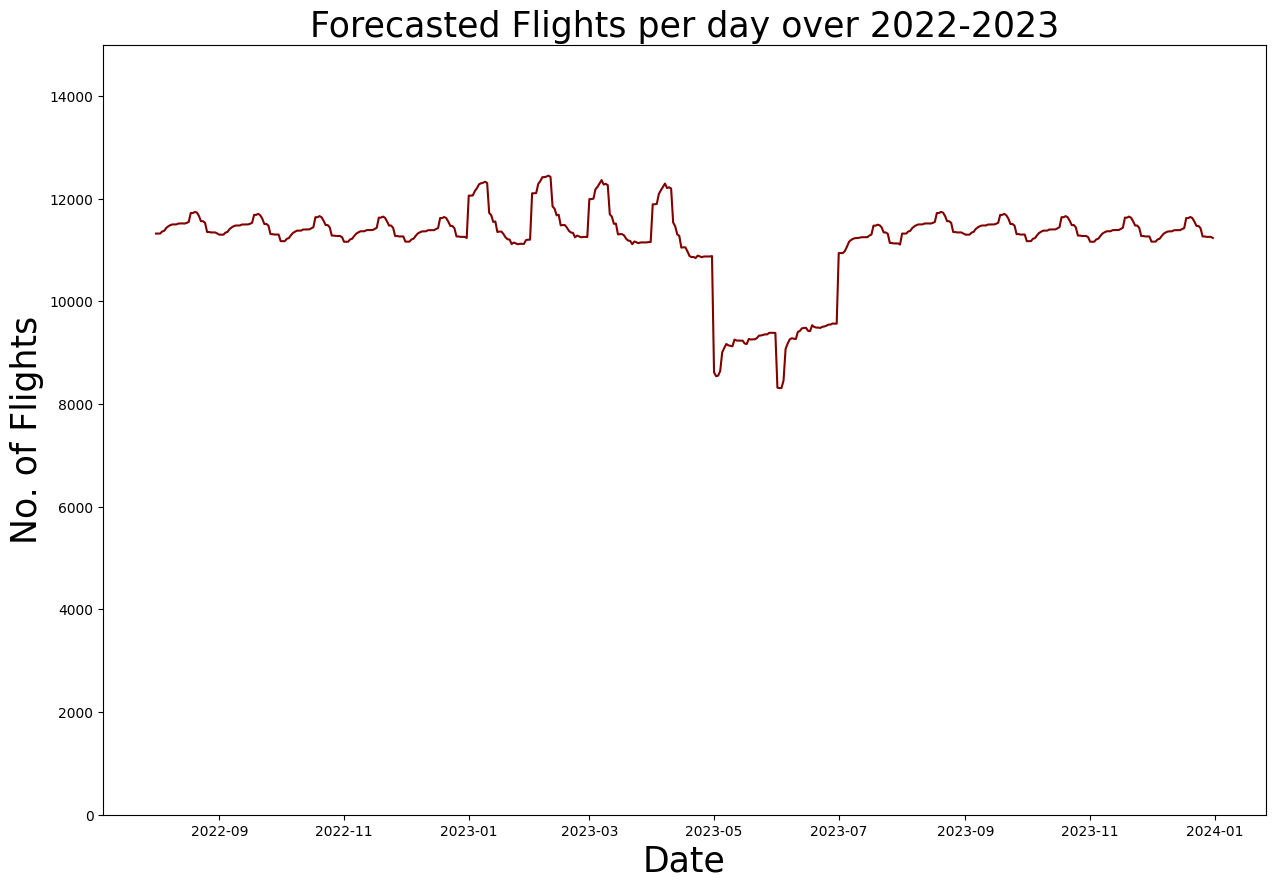

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# generate dates from September 2022 to May 2023
dates = pd.date_range(start='2022-08-01', end='2023-12-31', freq='D')

# combine with input data
all_dates = pd.date_range(start='2018-01-01', end='2023-12-31', freq='D')
historic_numflights = dfpd_flights['Num_Flights']
his_flights = historic_numflights.to_numpy()
all_numflights = np.concatenate((his_flights, np.round(predictions_denorm1)))

# Add axis labels and a title
fig = plt.figure(figsize = (15, 10))
ax = plt.axes()
# Create the line plot
plt.plot(dates, np.round(predictions_denorm1), color ='maroon')
#plt.plot(all_dates, all_numflights)
plt.xlabel('Date', fontsize=25)
plt.ylabel('No. of Flights', fontsize=25)
#plt.title("Flights per day over 2018-2023", fontsize=25)
plt.title("Forecasted Flights per day over 2022-2023", fontsize=25)
# Set y-axis limits to start from 0
plt.ylim(0, 15000)

# Show the plot
plt.show()

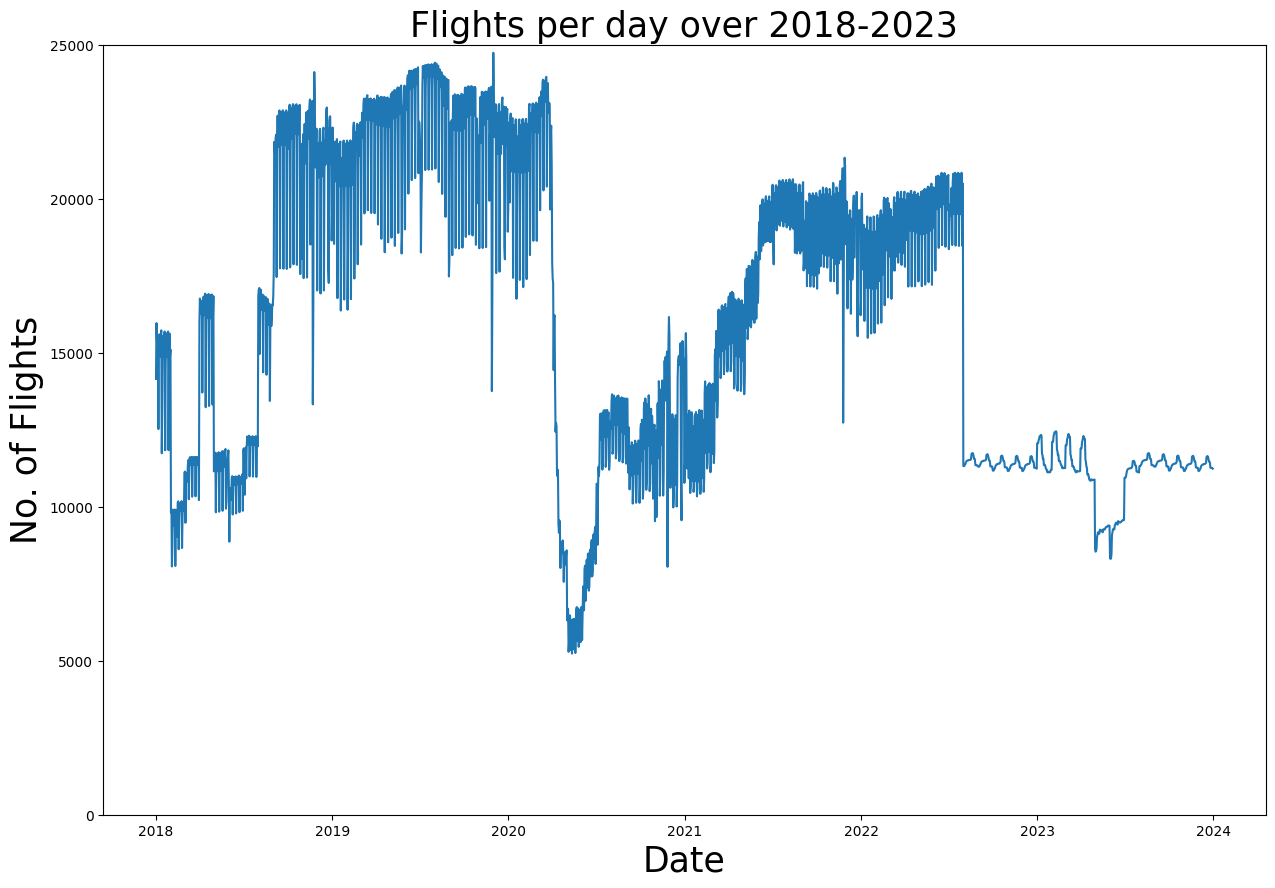

In [ ]:
# Add axis labels and a title
fig = plt.figure(figsize = (15, 10))
ax = plt.axes()
# Create the line plot
plt.plot(all_dates, all_numflights)
plt.xlabel('Date', fontsize=25)
plt.ylabel('No. of Flights', fontsize=25)
plt.title("Flights per day over 2018-2023", fontsize=25)

# Set y-axis limits to start from 0
plt.ylim(0, 25000)

# Show the plot
plt.show()

## ARIMA

For ARIMA (Autoregressive Integrated Moving Average) models, it is generally recommended to use StandardScaler to normalize the input data.

ARIMA models assume that the input time series data is stationary, meaning that its statistical properties (such as mean and variance) are constant over time. StandardScaler, which scales the data to have zero mean and unit variance, can help to stabilize the statistical properties of the input time series and make it more stationary.

TO DO: use autocorrelation plots to determine best parameters p, d, and q. Right now they are all set to 1 and this is not optimal. Also check the stationarity of the data with statistical tests.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
dfpd_flights = pd.read_parquet('/content/drive/MyDrive/DA/forecastDF_correct') 
# sort rows according to date
dfpd_flights = dfpd_flights.sort_values('Date')

In [ ]:
# one hot encode pandemic column
dfpd_flights = pd.get_dummies(dfpd_flights, columns=['Pandemic'])

In [ ]:
dfpd_flights

In [ ]:
#dfpd_flights["Date"] = dfpd_flights["Date"].astype(str)

In [ ]:
dfpd_flights["Date"] = pd.to_datetime(dfpd_flights["Date"])

In [ ]:
# without normalization
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load the data
data = dfpd_flights

# Set the index to the date column
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Split into train and test sets
train_data = data.loc[:'2022-06-30']
test_data = data.loc['2022-07-01':]

# Fit ARIMA model on training data
model = sm.tsa.statespace.SARIMAX(train_data['Num_Flights'], order=(1,1,1), seasonal_order=(0,1,1,12))
results = model.fit()

# Walk forward through test set and make predictions
predictions = []
for i in range(len(test_data)):
    # Fit model on updated training data
    train = data[:len(train_data)+i]
    model = sm.tsa.statespace.SARIMAX(train['Num_Flights'], order=(1,1,1), seasonal_order=(0,1,1,12))
    results = model.fit()
    
    # Make prediction for next time step
    pred = results.forecast(steps=1, exog=test_data.iloc[[i]][['Avg_Delay', 'Sum_Cancelled', 'Sum_Diverted', 'Pandemic']])
    predictions.append(pred[0])
    
# Calculate MSE
mse = np.mean((test_data['Num_Flights'].values - predictions)**2)
print("Mean squared error:", mse)

In [ ]:
# Generate future dates
start_date = data.index[-1] + pd.DateOffset(days=1)
end_date = start_date + pd.DateOffset(years=1)
future_dates = pd.date_range(start_date, end_date, freq='MS')

# Create exogenous variable DataFrame for future dates
exog = pd.DataFrame({'Avg_Delay': 0, 'Sum_Cancelled': 0, 'Sum_Diverted': 0, 'Pandemic': 0}, index=future_dates)

# Make predictions for next year
predictions= results.predict(start =start_date, end=end_date,exog=exog)
pred= results.forecast(steps=1, exog=exog)

In [ ]:
dates = pd.date_range(start='2022-08-01', end='2023-08-01', freq='D')
# Add axis labels and a title
fig = plt.figure(figsize = (15, 10))
ax = plt.axes()
# Create the line plot
plt.plot(dates, np.round(predictions), color ='maroon')
#plt.plot(all_dates, all_numflights)
plt.xlabel('Date', fontsize=25)
plt.ylabel('No. of Flights', fontsize=25)
#plt.title("Flights per day over 2018-2023", fontsize=25)
plt.title("Forecasted Flights per day over 2022-2023", fontsize=25)
# Set y-axis limits to start from 0
#plt.ylim(0, 15000)

# Show the plot
plt.show()

In [ ]:
# RUN 1
import pandas as pd
dfpd_flights = pd.read_parquet('/content/drive/MyDrive/DA/forecastDF_correct') 
# sort rows according to date
dfpd_flights = dfpd_flights.sort_values('Date')

In [ ]:
# RUN 2
# with normalization

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load the data
data = dfpd_flights

# Set the index to the date column
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Split into train and test sets
train_data = data.loc[:'2022-06-30']
test_data = data.loc['2022-07-01':'2022-07-03']
#test_data = data.loc['2022-07-01':] # SHOULD BE THIS

# Normalize the data
scaler2 = StandardScaler()
train_data_norm = pd.DataFrame(scaler2.fit_transform(train_data), columns=train_data.columns, index=train_data.index)
test_data_norm = pd.DataFrame(scaler2.transform(test_data), columns=test_data.columns, index=test_data.index)

# Fit ARIMA model on training data
model2 = sm.tsa.statespace.SARIMAX(train_data_norm['Num_Flights'], order=(1,1,1), seasonal_order=(0,1,1,12))
results = model2.fit()

# Walk forward through test set and make predictions
predictions = []
for i in range(len(test_data_norm)):
    # Fit model on updated training data
    train = data[:len(train_data)+i]
    train_norm = pd.DataFrame(scaler2.transform(train), columns=train.columns, index=train.index)
    model = sm.tsa.statespace.SARIMAX(train_norm['Num_Flights'], order=(1,1,1), seasonal_order=(0,1,1,12))
    results = model.fit()
    
    # Make prediction for next time step
    #pred_norm = results.forecast(steps=1, exog=test_data_norm.iloc[[i]][['Avg_Delay', 'Sum_Cancelled', 'Sum_Diverted', 'Pandemic']].values.reshape(1, -1))
    #pred = scaler2.inverse_transform(pred_norm.values.reshape(1, -1))[0][0]
    pred_norm = results.forecast(steps=1, exog=test_data_norm.iloc[[i]][['Avg_Delay', 'Sum_Cancelled', 'Sum_Diverted', 'Pandemic']].values.reshape(1, -1))
    shapedpred =  pd.DataFrame(pred_norm)
    shapedpred[['Avg_Delay' ,	'Sum_Cancelled',	'Sum_Diverted', 'Pandemic']] = 0	
    shapedpred.columns = ['Num_Flights', 'Avg_Delay' ,	'Sum_Cancelled',	'Sum_Diverted', 'Pandemic']	
    #pred = scaler2.inverse_transform(pred_norm.values.reshape(1, 5))[0][0]
    pred = scaler2.inverse_transform(shapedpred)
    print(pred)
    predictions.append(pred)
    
# Calculate MSE
predictions = np.array(predictions)
predictions = predictions.squeeze()
mse = np.mean((test_data['Num_Flights'].values - predictions[:,3])**2)
print("Mean squared error:", mse)


In [ ]:
test_data['Num_Flights'].values

array([20772, 18363, 18780])

In [ ]:
mse = np.mean((test_data['Num_Flights'].values - predictions[:,3])**2)
print("Mean squared error:", mse)


Mean squared error: 4724330.648057024


In [ ]:
shapedpred =  pd.DataFrame(pred_norm)
shapedpred[['Avg_Delay' ,	'Sum_Cancelled',	'Sum_Diverted', 'Num_Flights']] = 'NaN'	
shapedpred.columns = ['Num_Flights', 'Avg_Delay' ,	'Sum_Cancelled',	'Sum_Diverted', 'Pandemic']	

In [ ]:
predictions = np.array(predictions)

In [ ]:
predictions = predictions.squeeze()

In [ ]:
predictions[:,3]

array([17402.55298417, 17402.55298417, 17402.55298417])

In [ ]:
shapedpred

,Num_Flights,Avg_Delay,Sum_Cancelled,Sum_Diverted,Pandemic
2022-07-03,0.453354,0,0,0,0


## Other

In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor


# Define hyperparameters and ranges to be tuned
param_grid = {
    'n_estimators': [200, 300, 400, 500],
    'learning_rate': [0.001, 0.005, 0.01, 0.1, 1],
    'max_depth': [3, 5, 7]
}

# Create XGBoostRegressor model
xgb_model = XGBRegressor()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=10, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


Best parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best score:  0.9056783542731981


In [ ]:
# Walk forward validation with grid search - but this runs forever FIX
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import GridSearchCV

# Define window size for walk-forward validation
window_size = 50

# Define parameter grid for XGBoost hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
}

# Define XGBoostRegressor model
xgb_model = XGBRegressor()

# Initialize GridSearchCV with XGBoostRegressor model and parameter grid
grid_search = GridSearchCV(xgb_model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=5)

# Initialize list to store RMSE scores for each fold
rmse_scores = []

# Loop over the sliding window of train-test splits
for i in range(window_size, len(X_train), window_size):
    # Define train and test splits for this fold
    X_train_fold = X_train[i-window_size:i]
    y_train_fold = y_train[i-window_size:i]
    X_test_fold = X_train[i-window_size:i]
    y_test_fold = y_train[i-window_size:i]
    
    # Fit the GridSearchCV object to the training data for this fold
    grid_search.fit(X_train_fold, y_train_fold)
    
    # Get the best estimator from the GridSearchCV object
    best_model = grid_search.best_estimator_
    
    # Make predictions on the test data for this fold using the best estimator
    y_pred_fold = best_model.predict(X_test_fold)
    
    # Calculate RMSE for this fold and add it to the list of scores
    rmse_scores.append(sqrt(mean_squared_error(y_test_fold, y_pred_fold)))

# Calculate the mean RMSE score across all folds
mean_rmse = np.mean(rmse_scores)

# Print the mean RMSE score
print("Mean RMSE score: ", mean_rmse)

# Print the best hyperparameters found by GridSearchCV
print("Best hyperparameters: ", grid_search.best_params_)


In [ ]:
import pickle
file = open('/content/drive/MyDrive/DA/xgboostWalk.pkl', 'rb')
xgb_model = pickle.load(file)

In [ ]:
# save models
import pickle
pickle.dump(model, open('/content/drive/MyDrive/DA/xgboostCrossVal.pkl', 'wb'))
